In [2]:
import pandas as pd
import networkx as nx
import os
import configparser
import itertools
import json

In [3]:
config = configparser.ConfigParser()
config.read('rules.ini')

settings = {}
settings['path'] = config['RULES']['path']
settings['variation'] = config['RULES']['variation'][0]
settings['prop_variation'] = float(config['RULES']['variation'][1:])

In [4]:
path = r'C:\DanielBaron\GenerativeLSTM\output_files\20230417_3E8ABBDA_765B_4740_A305_D925CF5DE07C'
org_log_path = os.path.join(path, 'parameters', 'original_log.csv')

df_org = pd.read_csv(org_log_path)
df_org['start_timestamp'] = pd.to_datetime(df_org['start_timestamp'])
df_org['end_timestamp'] = pd.to_datetime(df_org['end_timestamp'])
df_org['rank'] = df_org.groupby('caseid')['start_timestamp'].rank().astype(int)

In [5]:
ac_index = dict(zip(df_org.task, df_org.ac_index))

In [6]:
path = r'C:\DanielBaron\GenerativeLSTM\output_files\20230417_3E8ABBDA_765B_4740_A305_D925CF5DE07C'
gen_log_path = os.path.join(path, 'parameters', 'generated_log.csv')

df_gen = pd.read_csv(gen_log_path)
df_gen['start_timestamp'] = pd.to_datetime(df_gen['start_timestamp'])
df_gen['end_timestamp'] = pd.to_datetime(df_gen['end_timestamp'])
df_gen['rank'] = df_gen.groupby('caseid')['start_timestamp'].rank().astype(int)

In [7]:
act_paths = list(itertools.product(*[x if type(x) is list else [x] for x in [json.loads(x.strip()) for x in settings['path'].split('>>')] ]))
act_paths_idx = [(ac_index[x[0]], ac_index[x[1]]) for x in act_paths]

## Add edges

In [11]:
class GenerateStats:
    def __init__(self, log, ac_index, ac_paths) -> None:
        self.log = log
        self.log['start_timestamp'] = pd.to_datetime(self.log['start_timestamp'])
        self.log['end_timestamp'] = pd.to_datetime(self.log['end_timestamp'])
        self.log['rank'] = self.log.groupby('caseid')['start_timestamp'].rank().astype(int)
        self.ac_index = ac_index
        self.ac_paths = ac_paths

    def evaluate_condition(self, df_case):
        df_case = df_case.sort_values(by='rank')
        u_tasks = [self.ac_index[x] for x in df_case['task'].drop_duplicates()]
        
        G = nx.DiGraph()
        for task in u_tasks:
            G.add_node(task)

        tasks = list(df_case['task'])
        if list(df_case['rank']) == list(set(list(df_case['rank']))):
            order = [(self.ac_index[x[0]], self.ac_index[x[1]]) for x in [(a, b) for a, b in zip(tasks[:-1], tasks[1:])]]
        else:
            order = []
            for i in range(1, len(df_case['rank'])):
                c_task = list(df_case[df_case['rank']==i]['task'])
                n_task = list(df_case[df_case['rank']==i+1]['task'])
                order += [(self.ac_index[x[0]], self.ac_index[x[1]]) for x in list(itertools.product(c_task, n_task))]

        G.add_edges_from(order)
        conds = [nx.is_simple_path(G, act_path) for act_path in act_paths_idx]

        return min(conds)

    def get_stats(self):

        pos_cases = 0
        total_cases = len(self.log['caseid'].drop_duplicates())
        for caseid in self.log['caseid'].drop_duplicates():

            df_case = self.log[self.log['caseid']==caseid]
            cond = self.evaluate_condition(df_case)
            if cond:
                pos_cases += 1

        return pos_cases, total_cases

In [12]:
gs = GenerateStats(df_org, ac_index, act_paths_idx)

In [41]:
from pandas import Timestamp
from support_modules import traces_evaluation as te

In [57]:
settings = te.extract_rules()
settings

{'path': '"Final Inspection Q.C." >> "Round Grinding"',
 'variation': '+',
 'prop_variation': 0.1,
 'act_paths': [('Final Inspection Q.C.', 'Round Grinding')]}

In [58]:
trace = [{'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 00:00:00'), 'end_timestamp': Timestamp('2012-03-13 02:09:16'), 'dur_raw': 0.09367651, 'dur': 7756.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 02:09:16'), 'end_timestamp': Timestamp('2012-03-13 04:09:57'), 'dur_raw': 0.08744754, 'dur': 7241.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 04:09:57'), 'end_timestamp': Timestamp('2012-03-13 06:00:14'), 'dur_raw': 0.07991026, 'dur': 6617.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'Role 3', 'start_timestamp': Timestamp('2012-03-13 06:00:14'), 'end_timestamp': Timestamp('2012-03-13 07:39:38'), 'dur_raw': 0.07202387, 'dur': 5964.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 3', 'start_timestamp': Timestamp('2012-03-13 07:39:38'), 'end_timestamp': Timestamp('2012-03-13 09:10:13'), 'dur_raw': 0.06563606, 'dur': 5435.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'Role 3', 'start_timestamp': Timestamp('2012-03-13 09:10:13'), 'end_timestamp': Timestamp('2012-03-13 10:34:54'), 'dur_raw': 0.061369464, 'dur': 5081.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 10:34:54'), 'end_timestamp': Timestamp('2012-03-13 12:01:25'), 'dur_raw': 0.06269527, 'dur': 5191.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 12:01:25'), 'end_timestamp': Timestamp('2012-03-13 13:29:51'), 'dur_raw': 0.06408131, 'dur': 5306.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 13:29:51'), 'end_timestamp': Timestamp('2012-03-13 14:59:43'), 'dur_raw': 0.065124825, 'dur': 5392.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 14:59:43'), 'end_timestamp': Timestamp('2012-03-13 16:30:17'), 'dur_raw': 0.06562811, 'dur': 5434.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 16:30:17'), 'end_timestamp': Timestamp('2012-03-13 18:00:53'), 'dur_raw': 0.06565593, 'dur': 5436.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 3', 'start_timestamp': Timestamp('2012-03-13 18:00:53'), 'end_timestamp': Timestamp('2012-03-13 19:31:07'), 'dur_raw': 0.06538925, 'dur': 5414.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'Role 3', 'start_timestamp': Timestamp('2012-03-13 19:31:07'), 'end_timestamp': Timestamp('2012-03-13 21:01:06'), 'dur_raw': 0.06520532, 'dur': 5399.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-13 21:01:06'), 'end_timestamp': Timestamp('2012-03-13 22:30:58'), 'dur_raw': 0.06512189, 'dur': 5392.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'end', 'start_timestamp': Timestamp('2012-03-13 22:30:58'), 'end_timestamp': Timestamp('2012-03-14 00:00:50'), 'dur_raw': 0.065116175, 'dur': 5392.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Final Inspection Q.C.', 'role': 'Role 7', 'start_timestamp': Timestamp('2012-03-14 00:00:50'), 'end_timestamp': Timestamp('2012-03-14 01:30:44'), 'dur_raw': 0.065147564, 'dur': 5394.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Round Grinding', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-14 01:30:44'), 'end_timestamp': Timestamp('2012-03-14 03:00:41'), 'dur_raw': 0.06518093, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Round Grinding', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 03:00:41'), 'end_timestamp': Timestamp('2012-03-14 04:30:39'), 'dur_raw': 0.06519602, 'dur': 5398.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Round Grinding', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 04:30:39'), 'end_timestamp': Timestamp('2012-03-14 06:00:37'), 'dur_raw': 0.065197736, 'dur': 5398.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Lapping', 'role': 'Role 7', 'start_timestamp': Timestamp('2012-03-14 06:00:37'), 'end_timestamp': Timestamp('2012-03-14 07:30:35'), 'dur_raw': 0.06519316, 'dur': 5398.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Round Grinding', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 07:30:35'), 'end_timestamp': Timestamp('2012-03-14 09:00:33'), 'dur_raw': 0.06518809, 'dur': 5398.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Round Grinding', 'role': 'Role 7', 'start_timestamp': Timestamp('2012-03-14 09:00:33'), 'end_timestamp': Timestamp('2012-03-14 10:30:30'), 'dur_raw': 0.06518525, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Round Grinding', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 10:30:30'), 'end_timestamp': Timestamp('2012-03-14 12:00:27'), 'dur_raw': 0.06518478, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Lapping', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 12:00:27'), 'end_timestamp': Timestamp('2012-03-14 13:30:24'), 'dur_raw': 0.06518542, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Flat Grinding', 'role': 'Role 7', 'start_timestamp': Timestamp('2012-03-14 13:30:24'), 'end_timestamp': Timestamp('2012-03-14 15:00:21'), 'dur_raw': 0.06518625, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Lapping', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 15:00:21'), 'end_timestamp': Timestamp('2012-03-14 16:30:18'), 'dur_raw': 0.06518671, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Packing', 'role': 'Role 10', 'start_timestamp': Timestamp('2012-03-14 16:30:18'), 'end_timestamp': Timestamp('2012-03-14 18:00:15'), 'dur_raw': 0.065186836, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Final Inspection Q.C.', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 18:00:15'), 'end_timestamp': Timestamp('2012-03-14 19:30:12'), 'dur_raw': 0.06518674, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Packing', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 19:30:12'), 'end_timestamp': Timestamp('2012-03-14 21:00:09'), 'dur_raw': 0.06518663, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'end', 'start_timestamp': Timestamp('2012-03-14 21:00:09'), 'end_timestamp': Timestamp('2012-03-14 22:30:06'), 'dur_raw': 0.06518653, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}]

In [64]:
ac_index

{'Turning & Milling': 21,
 'Turning & Milling Q.C.': 22,
 'Laser Marking': 8,
 'Lapping': 7,
 'Round Grinding': 15,
 'Final Inspection Q.C.': 3,
 'Packing': 12,
 'Turning Q.C.': 23,
 'Flat Grinding': 5,
 'Grinding Rework': 6,
 'Setup': 17,
 'Turning': 20,
 'SETUP     Turning & Milling': 16,
 'Final Inspection': 2,
 'Rework Milling': 13,
 'Milling Q.C.': 10,
 'Milling': 9,
 'Fix': 4,
 'Round  Q.C.': 14,
 'Stress Relief': 18,
 'Turning Rework': 24,
 'Change Version': 1,
 'Turn & Mill. & Screw Assem': 19,
 'Nitration Q.C.': 11}

In [63]:
act_paths_idx = [(ac_index[x[0]], ac_index[x[1]]) for x in settings['act_paths']]
act_paths_idx

[(3, 15)]

In [60]:
df_case = pd.DataFrame.from_records(trace, index=list(trace[0].keys())).reset_index()
df_case['rank'] = df_case.groupby('caseid')['start_timestamp'].rank().astype(int)
df_case

,caseid,task,role,start_timestamp,end_timestamp,dur_raw,dur,wait_raw,wait,rank
0,Case43,Turning & Milling,Role 1,2012-03-13 00:00:00,2012-03-13 02:09:16,0.093677,7756.0,0,0.0,1
1,Case43,Turning & Milling,Role 1,2012-03-13 02:09:16,2012-03-13 04:09:57,0.087448,7241.0,0,0.0,2
2,Case43,Turning & Milling,Role 1,2012-03-13 04:09:57,2012-03-13 06:00:14,0.079910,6617.0,0,0.0,3
3,Case43,Turning & Milling Q.C.,Role 3,2012-03-13 06:00:14,2012-03-13 07:39:38,0.072024,5964.0,0,0.0,4
4,Case43,Turning & Milling,Role 3,2012-03-13 07:39:38,2012-03-13 09:10:13,0.065636,5435.0,0,0.0,5
5,Case43,Turning & Milling Q.C.,Role 3,2012-03-13 09:10:13,2012-03-13 10:34:54,0.061369,5081.0,0,0.0,6
6,Case43,Turning & Milling,Role 1,2012-03-13 10:34:54,2012-03-13 12:01:25,0.062695,5191.0,0,0.0,7
7,Case43,Turning & Milling,Role 1,2012-03-13 12:01:25,2012-03-13 13:29:51,0.064081,5306.0,0,0.0,8
8,Case43,Turning & Milling,Role 1,2012-03-13 13:29:51,2012-03-13 14:59:43,0.065125,5392.0,0,0.0,9
9,Case43,Turning & Milling Q.C.,Role 1,2012-03-13 14:59:43,2012-03-13 16:30:17,0.065628,5434.0,0,0.0,10


In [61]:
df_case = df_case.sort_values(by='rank')
u_tasks = [ac_index[x] for x in df_case['task'].drop_duplicates()]

G = nx.DiGraph()
for task in u_tasks:
    G.add_node(task)

tasks = list(df_case['task'])
if list(df_case['rank']) == list(set(list(df_case['rank']))):
    order = [(ac_index[x[0]], ac_index[x[1]]) for x in [(a, b) for a, b in zip(tasks[:-1], tasks[1:])]]
    print(1)
else:
    order = []
    for i in range(1, len(df_case['rank'])):
        c_task = list(df_case[df_case['rank']==i]['task'])
        n_task = list(df_case[df_case['rank']==i+1]['task'])
        order += [(ac_index[x[0]], ac_index[x[1]]) for x in list(itertools.product(c_task, n_task))]
    print(2)
G.add_edges_from(order)
conds = [nx.is_simple_path(G, act_path) for act_path in act_paths_idx]

1


## Prueba Union Simod

In [18]:
from bs4 import BeautifulSoup

path_asis = r'Simod-Coral-Version\outputs\20230417_84C5DFCD_FF3E_415F_A9ED_104A01FFB164\Production_ASIS.bpmn'

with open(path_asis, 'r') as f:
    data_asis = f.read()

bpmn_asis = BeautifulSoup(data_asis, "xml") 
sim_info_asis = str(bpmn_asis.find_all('qbp:processSimulationInfo')[0])
att_info_asis = data_asis.replace(sim_info_asis, '')

In [19]:
path_tobe = r'Simod-Coral-Version\outputs\20230417_84C5DFCD_FF3E_415F_A9ED_104A01FFB164\Production_TOBE.bpmn'

with open(path_tobe, 'r') as f:
    data_tobe = f.read()

bpmn_tobe = BeautifulSoup(data_tobe, "xml") 
sim_info_tobe = str(bpmn_tobe.find_all('qbp:processSimulationInfo')[0])
att_info_tobe = data_asis.replace(sim_info_tobe, '')

In [23]:
bpmn_rules_based = '{}\n{}'.format(att_info_tobe, sim_info_asis)

In [26]:
output_path_files = r'Simod-Coral-Version\outputs\20230417_84C5DFCD_FF3E_415F_A9ED_104A01FFB164\Production_RULE_BASED.bpmn'
with open(output_path_files, 'w') as file:
    file.write(bpmn_rules_based)

In [ ]:
def combine_models(model_asis_path, model_tobe_path, rules_model_path):

    with open(model_asis_path, 'r') as f:
        data_asis = f.read()

    bpmn_asis = BeautifulSoup(data_asis, "xml") 
    sim_info_asis = str(bpmn_asis.find_all('qbp:processSimulationInfo')[0])

    with open(model_tobe_path, 'r') as f:
        data_tobe = f.read()

    bpmn_tobe = BeautifulSoup(data_tobe, "xml") 
    sim_info_tobe = str(bpmn_tobe.find_all('qbp:processSimulationInfo')[0])
    att_info_tobe = data_asis.replace(sim_info_tobe, '')

    bpmn_rules_based = '{}\n{}'.format(att_info_tobe, sim_info_asis)

    with open(output_path_files, 'w') as file:
        file.write(rules_model_path)

## Extract rules

In [1]:
import pandas as pd
import networkx as nx
import os
import configparser
import itertools
import json

In [41]:
config = configparser.ConfigParser()
config.read('rules.ini')

settings = {}
settings['path'] = [x.strip() for x in config['RULES']['path'].split('>>')]
settings['variation'] = config['RULES']['variation'][0] if 'variation' in config.options('RULES') else None
settings['prop_variation'] = float(config['RULES']['variation'][1:]) if 'variation' in config.options('RULES') else None

if '*' in settings['path']:
    settings['rule'] = 'eventually'
elif '^' in settings['path']:
    settings['rule'] = 'not_allowed'
elif '>>' in settings['path'] and '*' not in settings['path'] and '^' not in settings['path']:
    settings['rule'] = 'directly'
elif '>>' not in settings['path'] and '*' not in settings['path'] and '^' not in settings['path']:
    settings['rule'] = 'required'

In [42]:
settings['path'] 

['Turning & Milling Q.C.', '*', 'Lapping']

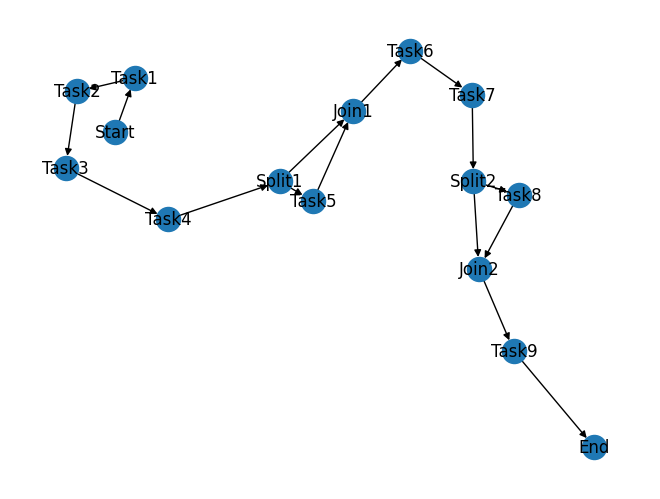

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# create an empty directed graph
G = nx.DiGraph()

# add nodes to the graph
G.add_node('Start')
G.add_node('Task1')
G.add_node('Task2')
G.add_node('Task3')
G.add_node('Task4')
G.add_node('Split1')
G.add_node('Task5')
G.add_node('Join1')
G.add_node('Task6')
G.add_node('Task7')
G.add_node('Split2')
G.add_node('Task8')
G.add_node('Join2')
G.add_node('Task9')
G.add_node('End')

# add edges to the graph
G.add_edge('Start', 'Task1')
G.add_edge('Task1', 'Task2')
G.add_edge('Task2', 'Task3')
G.add_edge('Task3', 'Task4')
G.add_edge('Task4', 'Split1')
G.add_edge('Split1', 'Task5')
G.add_edge('Split1', 'Join1')
G.add_edge('Task5', 'Join1')
G.add_edge('Join1', 'Task6')
G.add_edge('Task6', 'Task7')
G.add_edge('Task7', 'Split2')
G.add_edge('Split2', 'Task8')
G.add_edge('Split2', 'Join2')
G.add_edge('Task8', 'Join2')
G.add_edge('Join2', 'Task9')
G.add_edge('Task9', 'End')

# draw the graph with node labels
nx.draw(G, with_labels=True)
plt.show()

In [2]:
settings['bpmn_path']

'input_files\\bpmn_models\\PurchasingExample.bpmn'

In [1]:
import os
from support_modules import stochastic_model as sm

settings = dict()
settings['timeformat'] = "%Y-%m-%dT%H:%M:%S.%f"
settings['column_names'] = {'Case ID': 'caseid',
                            'Activity': 'task',
                            'lifecycle:transition': 'event_type',
                            'Resource': 'user'}
settings['one_timestamp'] = False
settings['filter_d_attrib'] = True

settings['file'] = 'PurchasingExample'
settings['sm3_path'] = os.path.join('external_tools', 'splitminer3', 'bpmtk.jar')
settings['concurrency'] = 0.0
settings['epsilon'] = 0.5
settings['eta'] = 0.7

settings['log_path'] = os.path.join('input_files', 'event_logs', settings['file'] + '.xes')
settings['tobe_bpmn_path'] = os.path.join('input_files', 'spmd', settings['file'] + '.bpmn')

spmd = sm.StochasticModel(settings)

parsing log, completed traces ::   0%|          | 0/608 [00:00<?, ?it/s]

Rearranging log traces ...      [DONE]
 -- Mining Process Structure --
Loading of bpmn structure from file 100.0%...      [DONE]
Counting branch cases...


100%|██████████| 608/608 [00:00<00:00, 86822.04it/s]


In [2]:
from support_modules import models_merger as mm


settings['bimp_path'] = os.path.join('external_tools', 'bimp', 'qbp-simulator-engine_with_csv_statistics.jar')
settings['asis_bpmn_path'] = os.path.join('input_files', 'simod', settings['file'] + '.bpmn')
settings['csv_output_path'] = os.path.join('output_files', 'simulation_stats', settings['file'] + '.csv')
settings['output_path'] = os.path.join('output_files', 'simulation_files', settings['file'] + '.bpmn')
settings['lrs'] = spmd.lrs

mod_mer = mm.MergeModels(settings)

Execution failed : Maximum allowed cycle time exceeded, maximum is 1095 days


In [39]:
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import subprocess

asis_bpmn_path = os.path.join('input_files', 'simod', 'PurchasingExample.bpmn')
tobe_bpmn_path = os.path.join('input_files', 'spmd', 'PurchasingExample.bpmn')

asis_tree = ET.parse(asis_bpmn_path)
asis_root = asis_tree.getroot()
tobe_tree = ET.parse(tobe_bpmn_path)
tobe_root = tobe_tree.getroot()
        
namespace = {'bpmn': 'http://www.omg.org/spec/BPMN/20100524/MODEL'}

asis_tasks = asis_root.findall('.//bpmn:task', namespace)
asis_tasks_data = {task.get('id'):task.get('name') for task in asis_tasks}

tobe_tasks = tobe_root.findall('.//bpmn:task', namespace)
tobe_tasks_data = {task.get('name'):task.get('id') for task in tobe_tasks}

In [40]:
with open(asis_bpmn_path, 'r') as f:
    data_asis = f.read()

asis_bpmn_xml = BeautifulSoup(data_asis, "xml") 
asis_sim_info = asis_bpmn_xml.find_all('qbp:processSimulationInfo')[0]
asis_elements = asis_sim_info.findAll('element')

for element in asis_elements:
    element_id_asis = element.get('elementId')
    task_asis = asis_tasks_data[element_id_asis]
    if task_asis in tobe_tasks_data.keys():
        element_id_tobe = tobe_tasks_data[task_asis]
        element['elementId'] = element_id_tobe

tobe_root.append(ET.fromstring(str(asis_sim_info)))

In [41]:
# Find the <sequenceFlows> section within <processSimulationInfo>
sequence_flows = asis_sim_info.find('qbp:sequenceFlows')
sequence_flows.decompose()

new_sequence_flows = asis_bpmn_xml.new_tag('qbp:sequenceFlows')

In [43]:
for key_node in spmd.lrs.branching_probs.keys():
    for key_task, value_task in spmd.lrs.branching_probs[key_node].items():
        new_seq_flow = asis_bpmn_xml.new_tag('qbp:sequenceFlow', elementId=key_task, executionProbability=value_task)
        new_sequence_flows.append(new_seq_flow)

In [54]:
output_path = os.path.join('output_files', 'simulation_files', 'PurchasingExample.bpmn')
tobe_tree.write(output_path, encoding='utf-8', xml_declaration=True)

In [56]:
bimp_sim_path = os.path.join('external_tools', 'bimp', 'qbp-simulator-engine_with_csv_statistics.jar')
csv_output = os.path.join('output_files', 'simulation_stats', 'PurchasingExample.csv')

def execute_simulator_simple(bimp_path, model_path, csv_output_path):
    args = ['java', '-jar', bimp_path, model_path, '-csv', csv_output_path]
    subprocess.run(args, stdout=open(os.devnull, 'wb'))

execute_simulator_simple(bimp_sim_path, output_path, csv_output)

In [1]:
import subprocess
import os

os.chdir('../Simod-2.3.1/')
bash_command = 'bash.sh'
file = "Production.xes"

subprocess.run([bash_command, file], shell=True)

CompletedProcess(args=['bash.sh', 'Production.xes'], returncode=0)

In [12]:
log

,caseid,task,user,start_timestamp,end_timestamp
0,gen-Case00,Lapping,Role 1,2012-03-13 05:23:18+0000,2012-03-13 08:10:32+0000
1,gen-Case00,Flat Grinding,Role 1,2012-03-14 01:54:15+0000,2012-03-14 03:28:46+0000
2,gen-Case00,Lapping,Role 2,2012-03-14 21:56:48+0000,2012-03-14 23:32:04+0000
3,gen-Case00,Laser Marking,Role 3,2012-03-15 17:58:15+0000,2012-03-15 19:22:00+0000
4,gen-Case00,Grinding Rework,Role 3,2012-03-16 12:39:48+0000,2012-03-16 14:03:15+0000
...,...,...,...,...,...
2431,gen-Case136,Final Inspection Q.C.,Role 5,2012-03-23 19:24:07+0000,2012-03-23 20:19:29+0000
2432,gen-Case144,Turning Q.C.,Role 2,2012-03-13 05:23:18+0000,2012-03-13 08:10:32+0000
2433,gen-Case144,Final Inspection Q.C.,Role 2,2012-03-13 18:38:07+0000,2012-03-13 20:04:51+0000
2434,gen-Case144,Final Inspection Q.C.,Role 3,2012-03-14 05:45:02+0000,2012-03-14 07:03:25+0000


In [14]:
import pandas as pd
from support_modules import xes_writer as xw

path = r'C:\DanielBaron\GenerativeLSTM\input_files\spmd\Production.csv'
log = pd.read_csv(path)

parameters = dict()
column_names = {'Case ID': 'caseid',
                'Activity': 'task',
                'lifecycle:transition': 'event_type',
                'Resource': 'user'}
parameters['one_timestamp'] = False  # Only one timestamp in the log
parameters['include_org_log'] = False
parameters['read_options'] = {
    'timeformat': "%Y-%m-%d %H:%M:%S%z",
    'column_names': column_names,
    'one_timestamp': parameters['one_timestamp'],
    'filter_d_attrib': False}

parameters['output_file'] = os.path.join('input_files', 'spmd', 'Production' + '.xes')

xw.XesWriter(log, parameters)

Importance: DEBUG
Message: Start serializing log to XES.XML

Importance: DEBUG
Message: finished serializing log (325.01220703125 msec.)



In [8]:
os.chdir('../GenerativeLSTM/')

In [36]:
a = {'node_8adc1df9-5391-4f59-a1b9-180c76b99301': {'node_b0179fbc-4f2c-4140-8b49-a232617b7f70': 0.26, 'node_5b2b98ee-2024-4cff-9825-04410fce5ebe': 0.3, 'node_f3e698b7-3a4d-41b4-9711-ac13475a5592': 0.14, 'node_8e485a88-d2b6-4732-b3c9-0aa7f61432c3': 0.3}, 'node_489fe063-1003-479f-8116-33ca5d7212bc': {'node_393551df-43c0-4051-b2db-22f34679be1d': 0.12, 'node_284b72c5-09cc-4cc7-b68c-f74fb0b28b8a': 0.88, 'node_178d91f6-4f4e-451e-948c-7b88441e7926': 0.0, 'node_4329cc2f-2e6c-409d-baad-6004c322a2b3': 0.0, 'node_f1263197-6d9c-4210-bb9e-b359ccf5c226': 0.0, 'node_76e23d82-9c44-49e9-baf3-9384e0246e55': 0.0, 'node_1956d023-de76-4111-b78d-eb27328cb0b3': 0.0, 'node_9b4ebe35-3708-49f4-a7cc-014768a862ec': 0.0, 'node_e07822d8-8f52-4fb2-9a95-33177ea3a3d8': 0.0}, 'node_1934f92a-30a6-4cdc-90ff-0e3ac7922667': {'node_e3618a82-acc8-4d60-b387-473bb9a05b01': 0.0, 'node_d18078bb-3372-43f8-8da9-b97478562541': 0.2399999999999999, 'node_d5eae97e-173d-42c6-ac9a-872b13237705': 0.12, 'node_9106eeda-6e8c-429d-9137-02ec40e81b69': 0.03, 'node_5b2b98ee-2024-4cff-9825-04410fce5ebe': 0.19, 'node_f3e698b7-3a4d-41b4-9711-ac13475a5592': 0.02, 'node_774dd6d1-b4c1-4cbb-9149-9c94cf879f6f': 0.05, 'node_8e485a88-d2b6-4732-b3c9-0aa7f61432c3': 0.2, 'node_2791527c-4da9-4e33-895a-ce32c346557b': 0.15, 'node_178d91f6-4f4e-451e-948c-7b88441e7926': 0.0, 'node_4329cc2f-2e6c-409d-baad-6004c322a2b3': 0.0, 'node_f1263197-6d9c-4210-bb9e-b359ccf5c226': 0.0, 'node_76e23d82-9c44-49e9-baf3-9384e0246e55': 0.0, 'node_1956d023-de76-4111-b78d-eb27328cb0b3': 0.0, 'node_9b4ebe35-3708-49f4-a7cc-014768a862ec': 0.0, 'node_e07822d8-8f52-4fb2-9a95-33177ea3a3d8': 0.0}, 'node_a3dcdee9-d426-446a-be43-9dcb2b314784': {'node_a5e902d4-9c36-4b71-8d7d-477b55de3de7': 0.01, 'node_4d0cfe75-63f6-4dc5-acc8-7f4a5bf45f66': 0.02, 'node_49ff5d15-db2c-4142-82bd-d9b90948342b': 0.01, 'node_156de982-f2ac-404a-b881-7e92d53c5851': 0.01, 'node_cebf4f0e-21c7-4add-a5da-1b6a7e9cd0b9': 0.05, 'node_d5eae97e-173d-42c6-ac9a-872b13237705': 0.74, 'node_284b72c5-09cc-4cc7-b68c-f74fb0b28b8a': 0.16, 'node_178d91f6-4f4e-451e-948c-7b88441e7926': 0.0, 'node_4329cc2f-2e6c-409d-baad-6004c322a2b3': 0.0, 'node_f1263197-6d9c-4210-bb9e-b359ccf5c226': 0.0, 'node_76e23d82-9c44-49e9-baf3-9384e0246e55': 0.0, 'node_1956d023-de76-4111-b78d-eb27328cb0b3': 0.0, 'node_9b4ebe35-3708-49f4-a7cc-014768a862ec': 0.0, 'node_e07822d8-8f52-4fb2-9a95-33177ea3a3d8': 0.0}, 'node_11224572-1fe6-4ceb-b268-d4a049b643e4': {'node_77c09226-b3ee-44ad-82ff-835da7890e3e': 0.0, 'node_d18078bb-3372-43f8-8da9-b97478562541': 0.33999999999999997, 'node_9106eeda-6e8c-429d-9137-02ec40e81b69': 0.07, 'node_5b2b98ee-2024-4cff-9825-04410fce5ebe': 0.3, 'node_f3e698b7-3a4d-41b4-9711-ac13475a5592': 0.02, 'node_19e6235b-0c22-4f95-8a9b-1a5997011d3e': 0.06, 'node_a2ee8eaf-406e-41c1-8f4f-18dcd2456ce3': 0.08, 'node_774dd6d1-b4c1-4cbb-9149-9c94cf879f6f': 0.02, 'node_2791527c-4da9-4e33-895a-ce32c346557b': 0.11, 'node_178d91f6-4f4e-451e-948c-7b88441e7926': 0.0, 'node_4329cc2f-2e6c-409d-baad-6004c322a2b3': 0.0, 'node_f1263197-6d9c-4210-bb9e-b359ccf5c226': 0.0, 'node_76e23d82-9c44-49e9-baf3-9384e0246e55': 0.0, 'node_1956d023-de76-4111-b78d-eb27328cb0b3': 0.0, 'node_9b4ebe35-3708-49f4-a7cc-014768a862ec': 0.0, 'node_e07822d8-8f52-4fb2-9a95-33177ea3a3d8': 0.0}, 'node_9c792d2e-400f-4aae-91eb-58b6e70ce569': {'node_75940595-1cca-4906-9826-cda66c82951a': 0.0, 'node_d18078bb-3372-43f8-8da9-b97478562541': 0.77, 'node_d5eae97e-173d-42c6-ac9a-872b13237705': 0.14, 'node_9106eeda-6e8c-429d-9137-02ec40e81b69': 0.08, 'node_284b72c5-09cc-4cc7-b68c-f74fb0b28b8a': 0.01, 'node_178d91f6-4f4e-451e-948c-7b88441e7926': 0.0, 'node_4329cc2f-2e6c-409d-baad-6004c322a2b3': 0.0, 'node_f1263197-6d9c-4210-bb9e-b359ccf5c226': 0.0, 'node_76e23d82-9c44-49e9-baf3-9384e0246e55': 0.0, 'node_1956d023-de76-4111-b78d-eb27328cb0b3': 0.0, 'node_9b4ebe35-3708-49f4-a7cc-014768a862ec': 0.0, 'node_e07822d8-8f52-4fb2-9a95-33177ea3a3d8': 0.0}, 'node_44c3acfc-6c9b-4897-bc8f-fe27cee81c1f': {'node_5b2b98ee-2024-4cff-9825-04410fce5ebe': 0.38, 'node_8e485a88-d2b6-4732-b3c9-0aa7f61432c3': 0.39, 'node_2791527c-4da9-4e33-895a-ce32c346557b': 0.23}, 'node_2a142494-95da-40e6-9534-bacbc96eb41a': {'node_4adb9ab6-f649-4ef0-96c2-ab5d57a2b58a': 0.03, 'node_d1973084-fe61-40ca-81bd-51032730bd44': 0.05, 'node_d5eae97e-173d-42c6-ac9a-872b13237705': 0.58, 'node_9106eeda-6e8c-429d-9137-02ec40e81b69': 0.34, 'node_178d91f6-4f4e-451e-948c-7b88441e7926': 0.0, 'node_4329cc2f-2e6c-409d-baad-6004c322a2b3': 0.0, 'node_f1263197-6d9c-4210-bb9e-b359ccf5c226': 0.0, 'node_76e23d82-9c44-49e9-baf3-9384e0246e55': 0.0, 'node_1956d023-de76-4111-b78d-eb27328cb0b3': 0.0, 'node_9b4ebe35-3708-49f4-a7cc-014768a862ec': 0.0, 'node_e07822d8-8f52-4fb2-9a95-33177ea3a3d8': 0.0}, 'node_022bf638-8ecf-420d-afc9-41490b01e78e': {'node_d18078bb-3372-43f8-8da9-b97478562541': 0.24999999999999978, 'node_d5eae97e-173d-42c6-ac9a-872b13237705': 0.17, 'node_9106eeda-6e8c-429d-9137-02ec40e81b69': 0.04, 'node_5b2b98ee-2024-4cff-9825-04410fce5ebe': 0.22, 'node_f3e698b7-3a4d-41b4-9711-ac13475a5592': 0.02, 'node_19e6235b-0c22-4f95-8a9b-1a5997011d3e': 0.05, 'node_774dd6d1-b4c1-4cbb-9149-9c94cf879f6f': 0.02, 'node_8e485a88-d2b6-4732-b3c9-0aa7f61432c3': 0.23, 'node_178d91f6-4f4e-451e-948c-7b88441e7926': 0.0, 'node_4329cc2f-2e6c-409d-baad-6004c322a2b3': 0.0, 'node_f1263197-6d9c-4210-bb9e-b359ccf5c226': 0.0, 'node_76e23d82-9c44-49e9-baf3-9384e0246e55': 0.0, 'node_1956d023-de76-4111-b78d-eb27328cb0b3': 0.0, 'node_9b4ebe35-3708-49f4-a7cc-014768a862ec': 0.0, 'node_e07822d8-8f52-4fb2-9a95-33177ea3a3d8': 0.0}, 'node_6fbf3437-7f61-4b35-be8f-818d9003a000': {'node_d5eae97e-173d-42c6-ac9a-872b13237705': 0.3, 'node_19e6235b-0c22-4f95-8a9b-1a5997011d3e': 0.14, 'node_8e485a88-d2b6-4732-b3c9-0aa7f61432c3': 0.56, 'node_178d91f6-4f4e-451e-948c-7b88441e7926': 0.0, 'node_4329cc2f-2e6c-409d-baad-6004c322a2b3': 0.0, 'node_f1263197-6d9c-4210-bb9e-b359ccf5c226': 0.0, 'node_76e23d82-9c44-49e9-baf3-9384e0246e55': 0.0, 'node_1956d023-de76-4111-b78d-eb27328cb0b3': 0.0, 'node_9b4ebe35-3708-49f4-a7cc-014768a862ec': 0.0, 'node_e07822d8-8f52-4fb2-9a95-33177ea3a3d8': 0.0}, 'node_609717b3-0ccc-4704-9afa-2cd3db773794': {'node_f81b80f0-6452-4425-9907-a71dd02a26c8': 0.01, 'node_1001b138-91f8-4ce9-9074-8d6a66ed9be0': 0.01, 'node_d18078bb-3372-43f8-8da9-b97478562541': 0.31, 'node_d5eae97e-173d-42c6-ac9a-872b13237705': 0.17, 'node_284b72c5-09cc-4cc7-b68c-f74fb0b28b8a': 0.01, 'node_5b2b98ee-2024-4cff-9825-04410fce5ebe': 0.24, 'node_8e485a88-d2b6-4732-b3c9-0aa7f61432c3': 0.25, 'node_178d91f6-4f4e-451e-948c-7b88441e7926': 0.0, 'node_4329cc2f-2e6c-409d-baad-6004c322a2b3': 0.0, 'node_f1263197-6d9c-4210-bb9e-b359ccf5c226': 0.0, 'node_76e23d82-9c44-49e9-baf3-9384e0246e55': 0.0, 'node_1956d023-de76-4111-b78d-eb27328cb0b3': 0.0, 'node_9b4ebe35-3708-49f4-a7cc-014768a862ec': 0.0, 'node_e07822d8-8f52-4fb2-9a95-33177ea3a3d8': 0.0}, 'node_725ed8a7-12dd-480a-8081-be9450e68ebd': {'node_d18078bb-3372-43f8-8da9-b97478562541': 0.24, 'node_b0179fbc-4f2c-4140-8b49-a232617b7f70': 0.01, 'node_cebf4f0e-21c7-4add-a5da-1b6a7e9cd0b9': 0.0, 'node_d5eae97e-173d-42c6-ac9a-872b13237705': 0.13, 'node_9106eeda-6e8c-429d-9137-02ec40e81b69': 0.04, 'node_5b2b98ee-2024-4cff-9825-04410fce5ebe': 0.18, 'node_19e6235b-0c22-4f95-8a9b-1a5997011d3e': 0.22, 'node_8e485a88-d2b6-4732-b3c9-0aa7f61432c3': 0.18, 'node_178d91f6-4f4e-451e-948c-7b88441e7926': 0.0, 'node_4329cc2f-2e6c-409d-baad-6004c322a2b3': 0.0, 'node_f1263197-6d9c-4210-bb9e-b359ccf5c226': 0.0, 'node_76e23d82-9c44-49e9-baf3-9384e0246e55': 0.0, 'node_1956d023-de76-4111-b78d-eb27328cb0b3': 0.0, 'node_9b4ebe35-3708-49f4-a7cc-014768a862ec': 0.0, 'node_e07822d8-8f52-4fb2-9a95-33177ea3a3d8': 0.0}}

In [37]:
for key in a:
    inner_dict = a[key]
    sum_probabilities = sum(inner_dict.values())
    if sum_probabilities != 1:
        adjustment = 1 - sum_probabilities
        print(adjustment)
        max_value_key = max(inner_dict, key=inner_dict.get)
        inner_dict[max_value_key] += adjustment

1.1102230246251565e-16
1.1102230246251565e-16


In [43]:
for key in a.keys():
    print(sum(a[key].values()))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
1.0
1.0
1.0


# Join files

In [34]:
from glob import glob
import os
import subprocess
import pandas as pd

In [35]:
def simulate(bimp_path, output_path, csv_output_path):
    args = ['java', '-jar', bimp_path, output_path, '-csv', csv_output_path]
    result = subprocess.run(args, stdout=subprocess.PIPE, text=True)
    print(result.returncode)
    if result.returncode == 0:
        print("Simulation was successfully executed")
        print(result.stdout.split('\n'))
    elif result.returncode == 1:
        execption_output = [result.stdout.split('\n')[i-1] for i in range(len(result.stdout.split('\n'))) if 'BPSimulatorException' in result.stdout.split('\n')[i]]
        print("Execution failed :", ' '.join(execption_output))

def extract_text(model_path, ptt_s, ptt_e):
    with open(model_path) as file:
        model= file.read()
    lines = model.split('\n')
    start, end = None, None
    for idx, line in enumerate(lines):
        if ptt_s in line and start == None:
            start = idx
        if ptt_e in line and end == None:
            end = idx
        if start != None and end != None:
            break
    return '\n'.join(lines[start+1:end])

def extract_stats(csv_output_path, event_log, rule, type_change, event_log_class):

    ptt_s = 'Scenario statistics'
    ptt_e = 'Process Cycle Time (s) distribution' 
    text = extract_text(csv_output_path, ptt_s, ptt_e)

    data = [x.split(',') for x in text.split('\n') if x != '']
    df = pd.DataFrame(data = data[1:], columns=data[0])

    df['Average'] = df['Average'].astype(float).astype(str).apply(lambda x: format(float(x),".2f")).astype(float)
    df['Average'], df['Units'] = zip(*df.apply(lambda x: (x['Average'], x['KPI']), axis=1))
    df['Average'] = df['Average'].round(2)
    df['Metric'] = df.apply(lambda x: x['KPI'].replace(' (s)', ''), axis=1)
    df['Event Log'] = event_log
    df['Type of change'] = type_change
    df['Rule'] = rule
    df['Event Log Type'] = event_log_class
    df = df[['Event Log', 'Event Log Type', 'Type of change', 'Rule', 'Metric', 'Min', 'Average', 'Max', 'Units']]

    return df

In [43]:
files_path = os.path.join('input_files', 'tests', 'simulation_files')
files = glob(files_path + '/*.bpmn')

bimp_path = os.path.join('external_tools', 'bimp', 'qbp-simulator-engine.jar')
for file in files:
    filename = file.split('\\')[-1].split('.')[0]
    csv_output_path = os.path.join('input_files', 'tests', 'simulation_stats', f'{filename}.csv')
    simulate(bimp_path, file, csv_output_path)

0
Simulation was successfully executed
['Running input_files\\tests\\simulation_files\\CDM-Restrictive-Cancelar curso not allowed.bpmn', '1 - EVENT START id: proc_29815118.node_2194a0a5-e008-4796-a77f-f5d1c5a66d9d index: 1 ', '17 - TASK (Start) id: proc_29815118.node_68a0223f-852d-4e9f-bdda-01f3d7d8c53a index: 17 ', '6 - TASK (Traer informacion estudiante - banner) id: proc_29815118.node_76ac4795-4788-45b0-a0d2-e2e30a469bcf index: 6 ', '3 - TASK (Radicar Solicitud Homologacion) id: proc_29815118.node_751fe22c-0286-418e-bd0a-a87a1dedaf8c index: 3 ', '20 - GATEWAY gw: XOR id: proc_29815118.node_37ad4f97-b9fa-4f60-97a8-33828c1a1aaa index: 20 ', '15 - TASK (Cancelar Solicitud) id: proc_29815118.node_02130f6c-b41f-4eae-9689-2c62337fe8c4 index: 15 ', '10 - TASK (Notificacion estudiante cancelacion soli) id: proc_29815118.node_c1585c52-9e6c-4bd0-b6ea-bc6f8768bdef index: 10 ', '28 - GATEWAY gw: XOR id: proc_29815118.node_6b30a85d-f8a2-415e-aa39-f34054791b40 index: 28 ', '14 - TASK (End) id: pr

In [37]:
files_path = os.path.join('output_files', 'simulation_files')
files = glob(files_path + '/*')

bimp_path = os.path.join('external_tools', 'bimp', 'qbp-simulator-engine_with_csv_statistics.jar')
for file in files:
    filename = file.split('\\')[-1].split('.')[0]
    csv_output_path = os.path.join('output_files', 'simulation_stats', f'{filename}.csv')
    simulate(bimp_path, file, csv_output_path)

0
Simulation was successfully executed
['Running output_files\\simulation_files\\Backup', 'Unable to load the model: Unable to parse BPMN file', 'com.qbpsimulator.engine.exceptions.ModelParseException: Unable to load the model: Unable to parse BPMN file', '\tat com.qbpsimulator.engine.BPSimulator.run(BPSimulator.java:224)', '\tat com.qbpsimulator.engine.Runner.main(Runner.java:68)', '']
0
Simulation was successfully executed
['Running output_files\\simulation_files\\CDM-Restrictive-Cancelar curso not allowed.bpmn', '1 - EVENT START id: proc_24460141.node_8e7e9a33-9465-4bab-af51-7f3be10976f0 index: 1 ', '14 - TASK (Start) id: proc_24460141.node_89177f73-2d0e-4b9f-a10e-725a90c89684 index: 14 ', '5 - TASK (Traer informacion estudiante - banner) id: proc_24460141.node_2393a30f-8223-4e52-bdb1-23129c2eed0a index: 5 ', '11 - TASK (Radicar Solicitud Homologacion) id: proc_24460141.node_9a4e7a88-989a-4db3-9046-ff99f98dc316 index: 11 ', '31 - GATEWAY gw: XOR id: proc_24460141.node_7c9d5c2b-25e8-

In [38]:
df_stats = pd.DataFrame(data=[], columns=['Event Log', 'Event Log Type', 'Type of change', 'Rule', 'Metric', 'Min', 'Average', 'Max', 'Units'])

manual_files = glob(os.path.join('input_files', 'tests', 'simulation_stats', '*.csv'))
for manual_file in manual_files:
    
    event_log = manual_file.split('\\')[-1].split('.')[0].split('-')[0]
    type_change = manual_file.split('\\')[-1].split('.')[0].split('-')[1]
    rule = manual_file.split('\\')[-1].split('.')[0].split('-')[2]
    
    df_stats_tmp = extract_stats(manual_file, event_log, rule, type_change, 'Manual')
    df_stats = pd.concat([df_stats, df_stats_tmp])

generated_files = glob(os.path.join('output_files', 'simulation_stats', '*.csv'))
for generated_file in generated_files:
    
    event_log = generated_file.split('\\')[-1].split('.')[0].split('-')[0]
    type_change = generated_file.split('\\')[-1].split('.')[0].split('-')[1]
    rule = generated_file.split('\\')[-1].split('.')[0].split('-')[2]
    
    df_stats_tmp = extract_stats(generated_file, event_log, rule, type_change, 'Generated')
    df_stats = pd.concat([df_stats, df_stats_tmp])

In [39]:
df_paper = df_stats.sort_values(by=['Metric', 'Type of change', 'Rule', 'Event Log Type'])[['Event Log', 'Event Log Type', 'Type of change', 'Rule', 'Metric','Average']]
df_paper = df_paper[df_paper['Metric'].isin(['Cost', 'Process Cycle Time'])]
df_paper = df_paper.pivot(index=['Event Log', 'Metric', 'Type of change', 'Rule'], columns='Event Log Type', values='Average')
df_paper = df_paper.reset_index()
df_paper['Error'] = abs((df_paper['Generated'] - df_paper['Manual']) / df_paper['Manual'])

In [41]:
df_paper

Event Log Type,Event Log,Metric,Type of change,Rule,Generated,Manual,Error
0,CDM,Cost,Restrictive,Cancelar curso not allowed,27.43,97.73,0.719329
1,CDM,Cost,Restrictive,Evaluacion curso is required,20.47,94.02,0.782280
2,CDM,Cost,Restrictive,Radicar Solicitud Homologacion eventually foll...,21.83,126.18,0.826993
3,CDM,Cost,Restrictive,Validar solicitud directly follows Radicar Sol...,28.96,85.85,0.662667
4,CDM,Process Cycle Time,Restrictive,Cancelar curso not allowed,38597.36,692479.20,0.944262
5,CDM,Process Cycle Time,Restrictive,Evaluacion curso is required,28193.21,360757.07,0.921850
6,CDM,Process Cycle Time,Restrictive,Radicar Solicitud Homologacion eventually foll...,20036.45,1402437.52,0.985713
7,CDM,Process Cycle Time,Restrictive,Validar solicitud directly follows Radicar Sol...,39351.13,460429.91,0.914534
8,P,Cost,Restrictive,Milling QC not allowed,170.52,NaN,NaN
9,P,Cost,Restrictive,Turning & Milling QC is required,1412.15,NaN,NaN


In [66]:
df_paper.to_excel(os.path.join('output_files', 'consolidated_results.xlsx'), index=False)

In [26]:
print(df_paper.to_latex(float_format='%.2f', index=False))

\begin{tabular}{lllrrr}
\toprule
Event Log & Rule & Metric & Generated & Manual & Error \\
\midrule
RunningExample & A eventually follows C & Accumulated Process Duration & 169600.17 & 190893.65 & 0.11 \\
RunningExample & A eventually follows C & Cost & 29.26 & 40.36 & 0.28 \\
RunningExample & A eventually follows C & Process Cycle Time & 169600.17 & 190893.65 & 0.11 \\
RunningExample & A eventually follows C & Process Waiting Time & 2216.50 & 3671.29 & 0.40 \\
RunningExample & C directly follows A & Accumulated Process Duration & 277552.34 & 168347.28 & 0.65 \\
RunningExample & C directly follows A & Cost & 66.67 & 20.84 & 2.20 \\
RunningExample & C directly follows A & Process Cycle Time & 277552.34 & 168320.38 & 0.65 \\
RunningExample & C directly follows A & Process Waiting Time & 6089.11 & 2020.99 & 2.01 \\
RunningExample & E directly follows C & Accumulated Process Duration & 187569.49 & 445099.33 & 0.58 \\
RunningExample & E directly follows C & Cost & 34.60 & 117.07 & 0.70 \\
R